In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from sklearn.utils import resample
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SpatialDropout1D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/indonesian-news-title.csv')
train.head()

,date,url,title,category
0,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Kemnaker Awasi TKA di Meikarta,finance
1,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,BNI Digitalkan BNI Java Jazz 2020,finance
2,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,"Terbang ke Australia, Edhy Prabowo Mau Genjot ...",finance
3,02/26/2020,https://finance.detik.com/moneter/d-4916133/oj...,OJK Siapkan Stimulus Ekonomi Antisipasi Dampak...,finance
4,02/26/2020,https://finance.detik.com/berita-ekonomi-bisni...,Saran Buat Anies-RK yang Mangkir Rapat Banjir ...,finance


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91017 entries, 0 to 91016
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      91017 non-null  object
 1   url       91017 non-null  object
 2   title     91017 non-null  object
 3   category  91017 non-null  object
dtypes: object(4)
memory usage: 2.8+ MB


In [4]:
train.size

364068

In [5]:
train['category'].value_counts()

,count
category,
news,32360
hot,16330
finance,14168
travel,6466
inet,5640
health,4919
oto,4383
food,4315
sport,2436


In [6]:
train.drop(train[(train['category'] == 'news') | (train['category'] == 'hot')].index, inplace=True)

min_count = train['category'].value_counts().min()
undersampled_dfs = []

In [7]:
# Undersampling setiap kategori
for category in train['category'].unique():
    df_category = train[train['category'] == category]
    df_category_undersampled = resample(
        df_category,
        replace=False,  # Tidak menggandakan data
        n_samples=min_count,  # Jumlah contoh sesuai kategori terkecil
        random_state=42  # Untuk konsistensi hasil
    )
    undersampled_dfs.append(df_category_undersampled)

# Menggabungkan kembali semua DataFrame hasil undersampling
train_undersampled = pd.concat(undersampled_dfs)

In [8]:
train_undersampled['category'].value_counts()

,count
category,
finance,2436
food,2436
health,2436
inet,2436
oto,2436
sport,2436
travel,2436


In [9]:
train_undersampled = train_undersampled[['title','category']]
train_undersampled.head()

,title,category
3445,Bank Mega Renovasi SD Aloysius YPPK Tillemans ...,finance
13023,"Terlalu Dominan, Ahok Harus Apa Agar Tak Seper...",finance
5970,Cara Dapat Listrik Gratis bagi Pelaku Bisnis &...,finance
6392,RI Mau Ekspor Masker hingga APD karena Kelebih...,finance
7188,Kecewa! Nasabah Jiwasraya Tak Dapat Solusi Usa...,finance


In [10]:
# Preprocessing teks
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(train_undersampled['title'])
X = tokenizer.texts_to_sequences(train_undersampled['title'])
X = pad_sequences(X, maxlen=50)  # Sesuaikan panjang sequence

# Convert labels to categorical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_undersampled['category_encoded'] = label_encoder.fit_transform(train_undersampled['category'])
y = to_categorical(train_undersampled['category_encoded'])

# Split data menjadi train dan test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Build model LSTM
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=50))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(120, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X, y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 34s 132ms/step - accuracy: 0.3241 - loss: 1.6267 - val_accuracy: 0.1832 - val_loss: 5.9110
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.8630 - loss: 0.4109 - val_accuracy: 0.2430 - val_loss: 5.7849
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - accuracy: 0.9341 - loss: 0.2050 - val_accuracy: 0.2480 - val_loss: 6.7351
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step - accuracy: 0.9586 - loss: 0.1309 - val_accuracy: 0.2603 - val_loss: 7.1912
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 41s 123ms/step - accuracy: 0.9681 - loss: 0.1002 - val_accuracy: 0.2515 - val_loss: 7.9163
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 42s 125ms/step - accuracy: 0.9718 - loss: 0.0827 - val_accuracy: 0.2442 - val_loss: 8.7452
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 44s 140ms/step - accuracy: 0.9795 - loss: 0.0604 - val_accuracy: 0.2577 - val_loss: 9.7592


In [12]:
test_titles = [
    "Maskapai penerbangan menawarkan diskon besar-besaran untuk liburan",
    "Teknologi baru ini akan mengubah cara kita berinteraksi dengan dunia digital",
    "Perusahaan otomotif meluncurkan mobil listrik terbaru dengan fitur canggih",
    "Ahli kesehatan memberikan tips menjaga daya tahan tubuh di musim hujan",
    "Restoran ini menawarkan hidangan lezat dengan bahan-bahan lokal",
    "Tim bulu tangkis Indonesia sukses meraih medali emas di kejuaraan dunia",
    "Startup lokal mendapatkan pendanaan untuk proyek pengembangan teknologi ramah lingkungan",
    "Menjelajahi Keindahan Alam Indonesia, Destinasi Terbaik untuk Liburan Akhir Tahun",
    "Tren Digital 2024: Inovasi Teknologi yang Akan Mengubah Dunia Internet",
    "Mengenal Mobil Listrik: Teknologi Ramah Lingkungan yang Semakin Populer",
    "Cara Menjaga Kesehatan Mental di Tengah Kesibukan Sehari-hari",
    "Resep Makanan Sehat yang Mudah Dibuat di Rumah, Cocok untuk Menjaga Imunitas",
    "Persaingan Ketat di Piala Dunia 2024: Tim Favorit dan Pemain Kunci",
    "Tips Mengatur Keuangan Pribadi agar Lebih Stabil di Tahun 2024"
]


In [13]:
true_labels = ['travel', 'inet', 'oto', 'health', 'food', 'sport', 'finance', 'travel', 'inet', 'oto', 'health', 'food', 'sport', 'finance']

In [14]:
# Preprocess data test
test_sequences = tokenizer.texts_to_sequences(test_titles)
test_padded = pad_sequences(test_sequences, maxlen=50)

# Prediksi kategori
predictions = model.predict(test_padded)

# Mendapatkan kategori hasil prediksi
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Tampilkan hasil prediksi
for i, title in enumerate(test_titles):
    print(f"Judul: {title}")
    print(f"Kategori yang Diprediksi: {predicted_categories[i]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Judul: Maskapai penerbangan menawarkan diskon besar-besaran untuk liburan
Kategori yang Diprediksi: finance
--------------------------------------------------
Judul: Teknologi baru ini akan mengubah cara kita berinteraksi dengan dunia digital
Kategori yang Diprediksi: inet
--------------------------------------------------
Judul: Perusahaan otomotif meluncurkan mobil listrik terbaru dengan fitur canggih
Kategori yang Diprediksi: oto
--------------------------------------------------
Judul: Ahli kesehatan memberikan tips menjaga daya tahan tubuh di musim hujan
Kategori yang Diprediksi: health
--------------------------------------------------
Judul: Restoran ini menawarkan hidangan lezat dengan bahan-bahan lokal
Kategori yang Diprediksi: food
--------------------------------------------------
Judul: Tim bulu tangkis Indonesia sukses meraih medali emas di kejuaraan dunia
Kategori yang Diprediksi: sport
-----------------------------------------------

In [15]:
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))
accuracy = accuracy_score(true_labels, predicted_categories)

print(f"Akurasi pada data test: {accuracy * 100:.2f}%")

Akurasi pada data test: 71.43%


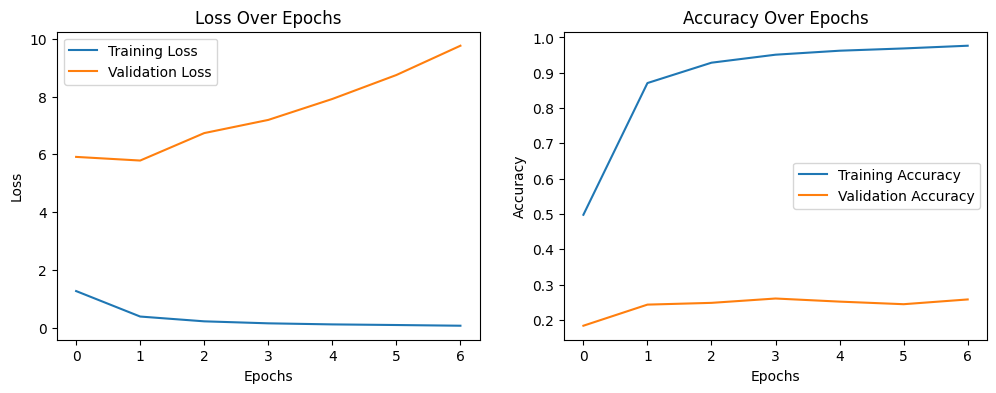

In [16]:
import matplotlib.pyplot as plt

# history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
# Plotting Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

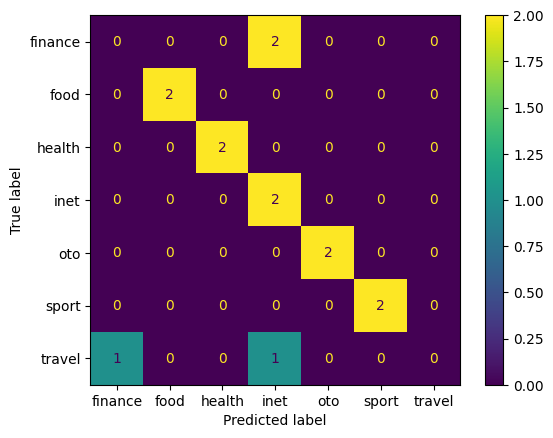

In [18]:
# Buat confusion matrix
cm = confusion_matrix(true_labels, predicted_categories)
class_names = ['finance',	'food',	'health',	'inet', 'oto', 'sport', 'travel']

# Menampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

In [19]:
# Build model LSTM
model2 = Sequential()
model2.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history2 = model2.fit(X, y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


214/214 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.3098 - loss: 1.6436 - val_accuracy: 0.2187 - val_loss: 4.8012
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.8395 - loss: 0.4979 - val_accuracy: 0.2416 - val_loss: 5.1989
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 41s 119ms/step - accuracy: 0.9253 - loss: 0.2404 - val_accuracy: 0.2636 - val_loss: 5.6366
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 40s 116ms/step - accuracy: 0.9542 - loss: 0.1483 - val_accuracy: 0.2565 - val_loss: 6.1661


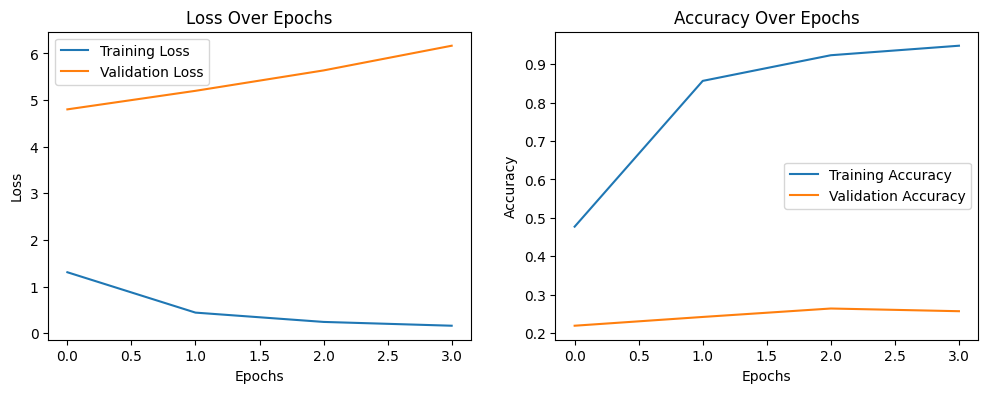

In [20]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
# Prediksi kategori
predictions = model2.predict(test_padded)

# Mendapatkan kategori hasil prediksi
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Tampilkan hasil prediksi
for i, title in enumerate(test_titles):
    print(f"Judul: {title}")
    print(f"Kategori yang Diprediksi: {predicted_categories[i]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Judul: Maskapai penerbangan menawarkan diskon besar-besaran untuk liburan
Kategori yang Diprediksi: finance
--------------------------------------------------
Judul: Teknologi baru ini akan mengubah cara kita berinteraksi dengan dunia digital
Kategori yang Diprediksi: inet
--------------------------------------------------
Judul: Perusahaan otomotif meluncurkan mobil listrik terbaru dengan fitur canggih
Kategori yang Diprediksi: oto
--------------------------------------------------
Judul: Ahli kesehatan memberikan tips menjaga daya tahan tubuh di musim hujan
Kategori yang Diprediksi: health
--------------------------------------------------
Judul: Restoran ini menawarkan hidangan lezat dengan bahan-bahan lokal
Kategori yang Diprediksi: food
--------------------------------------------------
Judul: Tim bulu tangkis Indonesia sukses meraih medali emas di kejuaraan dunia
Kategori yang Diprediksi: sport
-----------------------------------------------

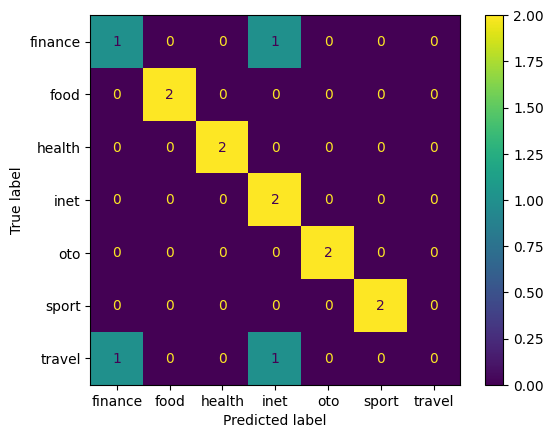

In [22]:
cm = confusion_matrix(true_labels, predicted_categories)
class_names = ['finance',	'food',	'health',	'inet', 'oto', 'sport', 'travel']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

In [23]:
predictions = model2.predict(test_padded)
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))
accuracy = accuracy_score(true_labels, predicted_categories)

print(f"Akurasi pada data test: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Akurasi pada data test: 78.57%


In [24]:
# Build model LSTM
model3 = Sequential()
model3.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
model3.add(SpatialDropout1D(0.2))
model3.add(LSTM(1000, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history3 = model3.fit(X, y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


214/214 ━━━━━━━━━━━━━━━━━━━━ 620s 3s/step - accuracy: 0.3130 - loss: 1.6167 - val_accuracy: 0.1733 - val_loss: 4.8236
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 607s 3s/step - accuracy: 0.8394 - loss: 0.4980 - val_accuracy: 0.2536 - val_loss: 5.5676
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 623s 3s/step - accuracy: 0.9159 - loss: 0.2712 - val_accuracy: 0.2510 - val_loss: 6.1202
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 635s 3s/step - accuracy: 0.9427 - loss: 0.1872 - val_accuracy: 0.2474 - val_loss: 6.7193


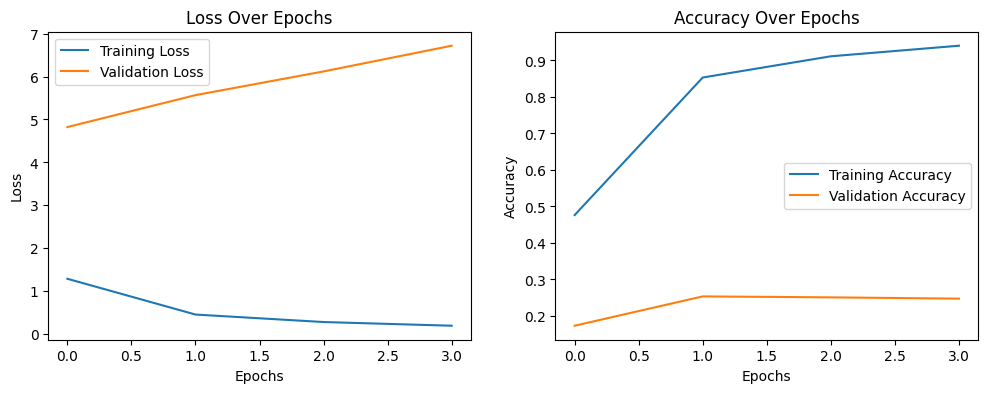

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
# Prediksi kategori
predictions = model3.predict(test_padded)

# Mendapatkan kategori hasil prediksi
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Tampilkan hasil prediksi
for i, title in enumerate(test_titles):
    print(f"Judul: {title}")
    print(f"Kategori yang Diprediksi: {predicted_categories[i]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Judul: Maskapai penerbangan menawarkan diskon besar-besaran untuk liburan
Kategori yang Diprediksi: finance
--------------------------------------------------
Judul: Teknologi baru ini akan mengubah cara kita berinteraksi dengan dunia digital
Kategori yang Diprediksi: inet
--------------------------------------------------
Judul: Perusahaan otomotif meluncurkan mobil listrik terbaru dengan fitur canggih
Kategori yang Diprediksi: oto
--------------------------------------------------
Judul: Ahli kesehatan memberikan tips menjaga daya tahan tubuh di musim hujan
Kategori yang Diprediksi: health
--------------------------------------------------
Judul: Restoran ini menawarkan hidangan lezat dengan bahan-bahan lokal
Kategori yang Diprediksi: food
--------------------------------------------------
Judul: Tim bulu tangkis Indonesia sukses meraih medali emas di kejuaraan dunia
Kategori yang Diprediksi: sport
-----------------------------------------------

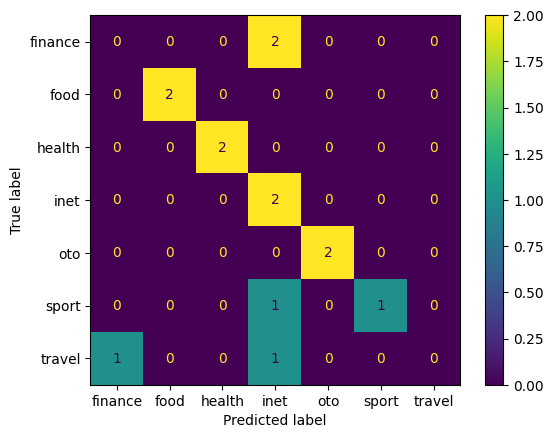

In [27]:
cm = confusion_matrix(true_labels, predicted_categories)
class_names = ['finance',	'food',	'health',	'inet', 'oto', 'sport', 'travel']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

In [28]:

predictions = model3.predict(test_padded)
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))
accuracy = accuracy_score(true_labels, predicted_categories)

print(f"Akurasi pada data test: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Akurasi pada data test: 64.29%


In [31]:
# Build model LSTM
model4 = Sequential()
model4.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
model4.add(SpatialDropout1D(0.3))
model4.add(LSTM(30, dropout=0.3, recurrent_dropout=0.3))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history4 = model4.fit(X, y, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


214/214 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.2770 - loss: 1.7550 - val_accuracy: 0.1630 - val_loss: 4.9818
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7919 - loss: 0.6525 - val_accuracy: 0.2492 - val_loss: 5.5600
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9026 - loss: 0.3161 - val_accuracy: 0.2592 - val_loss: 5.8741
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9335 - loss: 0.2192 - val_accuracy: 0.2562 - val_loss: 6.4584


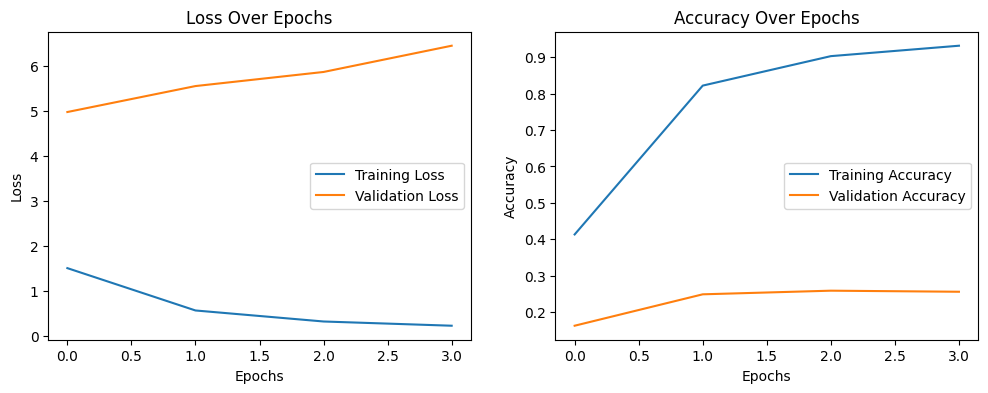

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Judul: Maskapai penerbangan menawarkan diskon besar-besaran untuk liburan
Kategori yang Diprediksi: finance
--------------------------------------------------
Judul: Teknologi baru ini akan mengubah cara kita berinteraksi dengan dunia digital
Kategori yang Diprediksi: inet
--------------------------------------------------
Judul: Perusahaan otomotif meluncurkan mobil listrik terbaru dengan fitur canggih
Kategori yang Diprediksi: oto
--------------------------------------------------
Judul: Ahli kesehatan memberikan tips menjaga daya tahan tubuh di musim hujan
Kategori yang Diprediksi: health
--------------------------------------------------
Judul: Restoran ini menawarkan hidangan lezat dengan bahan-bahan lokal
Kategori yang Diprediksi: food
--------------------------------------------------
Judul: Tim bulu tangkis Indonesia sukses meraih medali emas di kejuaraan dunia
Kategori yang Diprediksi: sport
-----------------------------------------------

In [32]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Prediksi kategori
predictions = model4.predict(test_padded)

# Mendapatkan kategori hasil prediksi
predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))

# Tampilkan hasil prediksi
for i, title in enumerate(test_titles):
    print(f"Judul: {title}")
    print(f"Kategori yang Diprediksi: {predicted_categories[i]}")
    print("-" * 50)

predicted_categories = label_encoder.inverse_transform(predictions.argmax(axis=1))
accuracy = accuracy_score(true_labels, predicted_categories)

print(f"Akurasi pada data test: {accuracy * 100:.2f}%")

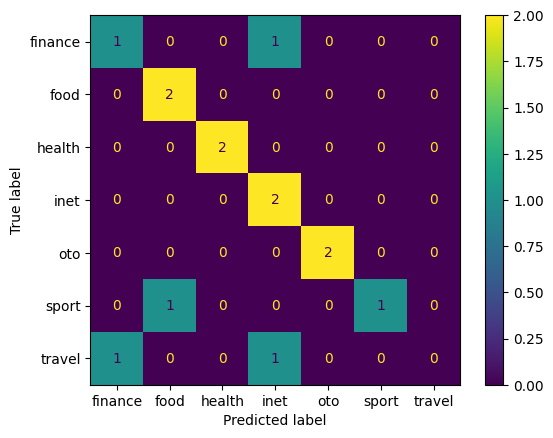

In [33]:
# Buat confusion matrix
cm = confusion_matrix(true_labels, predicted_categories)

# Jika Anda tahu label kelas, misalnya untuk 5 kategori: 'news', 'hot', 'finance', 'travel', 'inet'
class_names = ['finance',	'food',	'health',	'inet', 'oto', 'sport', 'travel']

# Menampilkan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

In [ ]:
# model.save('/content/drive/MyDrive/Colab Notebooks/model_klasifikasi_lstm4.keras')

In [ ]:
# from tensorflow.keras.models import load_model

# # Memuat model dari file
# loaded_model = load_model('model_rnn.keras')

# # Verifikasi bahwa model yang dimuat memiliki performa yang sama
# loss, accuracy = loaded_model.evaluate(X_test, y_test)
# print(f'Model loaded with accuracy: {accuracy:.2f}')
